### Get the digits and labels

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
#input: list of digit images
#output: plots of the digit images
def show_digits(digits):
    n = len(digits)
    if n==0:
        print("0 digits")
    fig, axs = plt.subplots(1, n, figsize=(70, 10))
    if n==1:
        print(digits[0].shape)
        axs.imshow(digits[0])
    else:
        for d in range(n):
            axs[d].set_title(str(digits[d].shape))
            axs[d].imshow(digits[d])
    plt.tight_layout()

#enter path to the 
path_to_training_dataset = r"/home/davo/COMP551/COMP551-Project3/10x10_adjusted_digits_and_labels_167874instances.hdf5"
with h5py.File(path_to_training_dataset, 'r') as f:
    print(f'Datasets in h5 file: {list(f.keys())}')
    #convert to long because pytorch requires categorical output to be long
    labels = np.array(f['labels'], dtype=np.long)
    #convert to float because pytorch requires inputs to be float
    digits = np.array(f['digits'], dtype=np.float32)
    print(f"Shape of labels: {labels.shape}")
    print(f"Shape of digits : {digits.shape}")

Datasets in h5 file: ['digits', 'labels']
Shape of labels: (167874,)
Shape of digits : (167874, 10, 10)


[5 9 1 5 1 4 2 4 9 2]


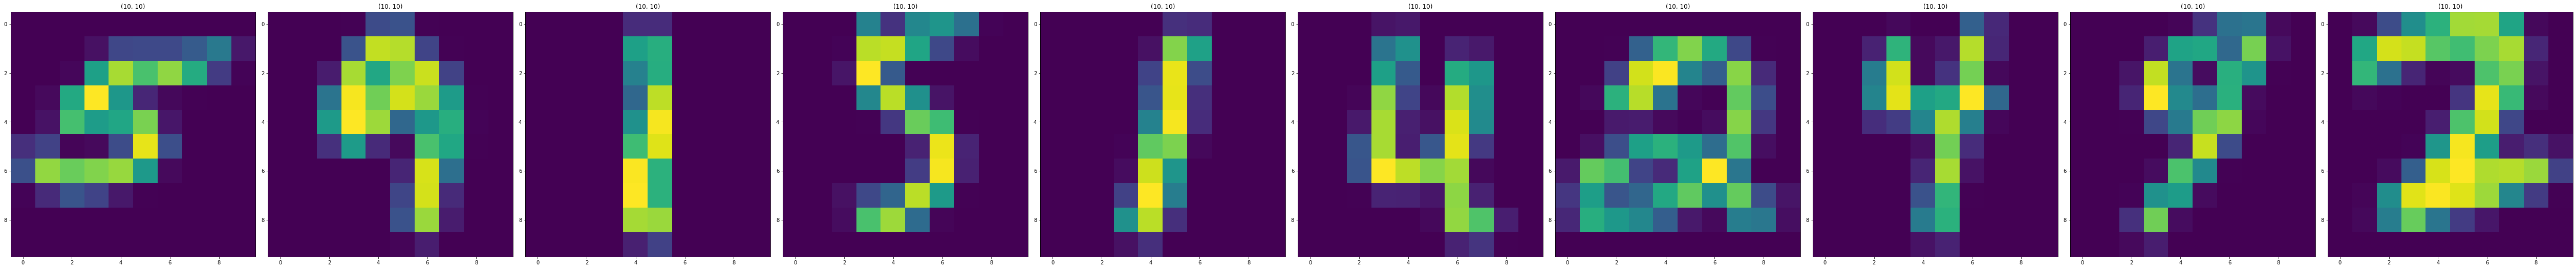

In [2]:
#check that the labels correspond to the digits
print(labels[20023:20033])
show_digits(digits[20023:20033])

### Build Neural Network

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import optim
import numpy as np
import copy
import pandas as pd

In [4]:
#functions used to train the model

#takes in the output from the model, computes class prpobabilites for each instance
#takes the class with greatest probability as prediciton, and computes accuracy based on the true classes y
#the model output should be a NxC tensor where N is number of instances and C number of classes. y is a Nx1 tensor
def softmax_accuracy(model_output, y):
    class_probs = model_output / model_output.exp().sum(-1).view(-1, 1)
    preds = torch.argmax(model_output, dim=1)
    return (class_probs.argmax(dim=1) == y).float().mean().item()

#when given an optimizer, this function computes the loss of 
#the prediciton made by the given model using the given loss_func.
#if not given an optimizer, it will also compute the accuracy
def loss_batch(model, loss_func, xb, yb, opt=None):
    model_output = model(xb)
    #compute the loss
    loss = loss_func(model_output, yb)
    #backrop if given an optimizer
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    #calculate accuracy if not given an optimizer
    acc = None
    if opt is None:
        acc = softmax_accuracy(model_output, yb)
    
    return acc, loss.item(), len(xb)

#computes the weighted average of the values, using the batch sizes as weights
def compute_average_weighted_by_batch_sizes(values, batch_sizes):
    return np.sum(np.multiply(values, batch_sizes)) / np.sum(batch_sizes)

#input: the training/validation data and labels must be tensors. batch size an integer
#output: training and validation DataLoaders
def get_DataLoaders(x_train, y_train, x_valid, y_valid, bs):
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    
    valid_ds = TensorDataset(x_valid, y_valid)
    valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
    
    return train_dl, valid_dl          

#for each epoch, fits model using the given parameters and DataLoaders
#output:
#   - epoch_stats: a dictionary of the dictionaries of the accuracies and losses at each epoch for tr and val
#   - best_epoch: the epoch number with the lowest validation loss (epochs start at 0)
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience):
    epoch_stats = {}
    #keep track of the number of epochs that have passed since the last time val_loss decreased
    count = 0
    for epoch in range(epochs):
        #train model using the batches in the train DataLoader
        model.train()
        for xb, yb in train_dl:
            #compute loss and backprop
            loss_batch(model, loss_func, xb, yb, opt)
            
        #once we finish going through the entire dataset (i.e. one epoch)
        #we compute the loss and accuracy on both the training and validation sets
        model.eval()
        with torch.no_grad():
            #note: the reason we compute the accs and losses in this weird way is (I think) because sometimes
            #the dataset might be too large to use all at the same time... 
            #(this is how it's done in "what is torch.nn really tutorial")
            val_accs, val_losses, val_batch_sizes = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
            tr_accs, tr_losses, tr_batch_sizes = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in train_dl])
        val_loss = compute_average_weighted_by_batch_sizes(val_losses, val_batch_sizes)
        tr_loss = compute_average_weighted_by_batch_sizes(tr_losses, tr_batch_sizes)
        val_acc = compute_average_weighted_by_batch_sizes(val_accs, val_batch_sizes)
        tr_acc = compute_average_weighted_by_batch_sizes(tr_accs, tr_batch_sizes)
        print(f"Epoch: {epoch}, val_loss: {val_loss}, train_loss: {tr_loss}\n\t  val_acc: {val_acc}, train_acc:{tr_acc}")
        
        #save the loss and accuracies on both sets in a dictionary under the key of the epoch
        #also save the model state so we can recover the best model
        epoch_stats[str(epoch)] = {'model_state_dict':copy.deepcopy(model.state_dict()), 'val_loss':val_loss, 
                                   'tr_loss':tr_loss, 'val_acc':val_acc, 'tr_acc':tr_acc}
        
        #if it's the 0th epoch, don't do anything
        if epoch == 0:
            continue
        #if not, then:
        else:
            #if the current val_loss is smaller than the smallest val_loss, set count to 0
            if epoch_stats[str(epoch)]['val_loss'] < epoch_stats[str(epoch-1-count)]['val_loss']:
                count = 0
            #if not, then add 1 to the count.
            else:
                count += 1
                
        #if it's been patience epochs since val_loss decreased, exit training  
        if count == patience:
            print(f"EARLY STOPPING!!!")
            break
            
    #return the epoch statistics dictionary and the epoch that gave us the smallest loss
    print(f"BEST_EPOCH: {str(epoch-count)}")
    return (epoch_stats, epoch-count) 

#creates a model, dataloaders and optimizer and calls the fit function
#returns the output of the fit method:
def train_and_validate_model(x_tr, y_tr, x_val, y_val, lr, mom, bs, epochs, patience):
    #create the DataLoaders that will handle the batch configurations
    train_dl, valid_dl = get_DataLoaders(x_tr, y_tr, x_val, y_val, bs=bs)
    #create the model
    model = Mnist_CNN()
    #create the optimizer
    opt = optim.SGD(model.parameters(), lr=lr, momentum=mom)
    return fit(epochs=epochs, patience=patience, model=model, loss_func=F.cross_entropy,
               opt=opt, train_dl=train_dl, valid_dl=valid_dl)

In [5]:
#Model. Make sure the model does not output softmax or any other type of probability. 
#this is calculated in the loss func
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(10, 56, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(56 * 5 * 5, 700)
        self.fc2 = nn.Linear(700, 350)
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(350, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 10)

    def forward(self, xb):
        #print(xb.shape)
        xb = xb.view(-1, 1, 10, 10); #print(xb.shape)
        xb = F.relu(self.conv1(xb)); #print(xb.shape)
        xb = F.relu(self.conv2(xb)); #print(xb.shape)
        xb = F.relu(self.conv3(xb)); #print(xb.shape)
        
        xb = self.maxpool(xb);       #print(xb.shape)
        
        xb = xb.view(-1, 56*5*5);    #print(xb.shape)
        
        xb = F.relu(self.fc1(xb));   #print(xb.shape)
        xb = F.relu(self.fc2(xb));   #print(xb.shape)
        xb = self.dropout(xb);
        xb = F.relu(self.fc3(xb));
        xb = F.relu(self.fc4(xb));
        xb = self.dropout(xb);
        xb = F.relu(self.fc5(xb));      
        return xb

In [6]:
#train and validate the model on a certain combination of: lr, mom, bs, epoch, patience
size_ds = len(digits) 
p = np.random.permutation(size_ds)
x_tr = digits[p][:(size_ds*9)//10]; y_tr = labels[p][:(size_ds*9)//10]
x_val = digits[p][(size_ds*9)//10:]; y_val = labels[p][(size_ds*9)//10:]
#convert the arrays into tensors
x_tr, y_tr, x_val, y_val = map(torch.tensor, (x_tr, y_tr, x_val, y_val))
#train and validate
epoch_stats, best_epoch = train_and_validate_model(x_tr, y_tr, x_val, y_val, lr=0.001, 
                                                  mom=0.99, bs=128, epochs=15, patience=4)

/home/davo/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch: 0, val_loss: 0.06171600854440135, train_loss: 0.054767326923977865
	  val_acc: 0.9817726948529958, train_acc:0.9840223448912435
Epoch: 1, val_loss: 0.04522104492406136, train_loss: 0.03304468219353792
	  val_acc: 0.9877293304741482, train_acc:0.9908065605019658
Epoch: 2, val_loss: 0.02616258969316106, train_loss: 0.019302509324380754
	  val_acc: 0.9929711696560223, train_acc:0.9940034152734204
Epoch: 3, val_loss: 0.017618616692765557, train_loss: 0.009980467176389902
	  val_acc: 0.9948772933047415, train_acc:0.996697245277524
Epoch: 4, val_loss: 0.015715406494664925, train_loss: 0.007258292985684001
	  val_acc: 0.9958303550154872, train_acc:0.9978158135101862
Epoch: 5, val_loss: 0.017650568314794914, train_loss: 0.008072595496177962
	  val_acc: 0.9939837979509173, train_acc:0.9958632831648095
Epoch: 6, val_loss: 0.013931048134741704, train_loss: 0.005635848070733727
	  val_acc: 0.9948772933047415, train_acc:0.9973657387183459
Epoch: 7, val_loss: 0.012762972739211592, train_loss:

In [10]:
torch.save(epoch_stats['6']['model_state_dict'], r'/home/davo/COMP551/COMP551-Project3/a_good_state_for_model_0.pt')

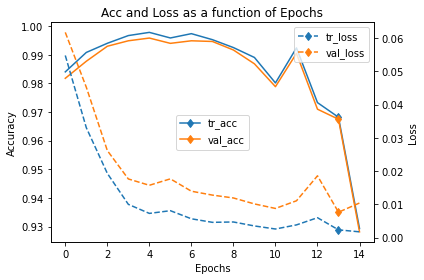

In [9]:
#input: epoch_stats dictionary (the output of train_and_validate_model) and best_epoch
#output: plots accs and vars with respect to epochs
def plot_accs_and_losses_wrt_epochs(epoch_stats, best_epoch):
    epoch_stats_df = pd.DataFrame.from_dict(epoch_stats).drop('model_state_dict', axis=0).transpose()
    
    fig, ax = plt.subplots()
    
    epoch_stats_df.plot(y=['tr_acc', 'val_acc'], ax=ax, style='-d', markevery=[best_epoch], 
                        title='Acc and Loss as a function of Epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    plt.legend(loc='center')
    
    ax2 = ax.twinx()
    epoch_stats_df.plot(y=['tr_loss', 'val_loss'], style = '--d', ax=ax2, markevery=[best_epoch])
    ax2.set_ylabel('Loss')
    plt.legend(loc='upper right')
    plt.tight_layout()
    
plot_accs_and_losses_wrt_epochs(epoch_stats, best_epoch)
    

In [1]:
#recover the best model found
best_model = Mnist_CNN()
best_model.load_state_dict(epoch_stats[str(best_epoch)]['model_state_dict'])
best_model.eval()
with torch.no_grad():
    print(f"validation acc: {softmax_accuracy(best_model(x_val), y_val)}")

NameError: name 'Mnist_CNN' is not defined

### Cross-validation and hyperparam grid search

In [6]:
#cross_validate takes in the number of datapoints (n) and the number of folds we want to divide our data into (n_folds)
#it then yields the training_indices and the validation_indices
def compute_cross_validation_indicies(n, n_folds):
    n_val = n // n_folds
    for f in range(n_folds):
        tr_inds = []
        val_inds = list(range(f * n_val, (f+1)*n_val))
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        yield tr_inds, val_inds

#creates a dataframe of the mean/var accs/losses for all combinations of hyperparameters
def create_hyper_grid(digits, labels, learning_rates, momentums, batch_sizes, epochs, patience, n_folds):
    #shuffle the data
    size_ds = len(digits)
    p = np.random.permutation(size_ds)
    digits = digits[p]; labels = labels[p];
    
    #initialize the hyper_grid
    hyper_grid_index = pd.MultiIndex.from_product([learning_rates, momentums, batch_sizes], names=['learning rate', 'momentum', 'batch size'])
    hyper_grid = pd.DataFrame(index=hyper_grid_index, columns=['val_acc_mean', 'tr_acc_mean', 'val_acc_var', 'tr_acc_var', 
                                                               'best_epoch_mean', 'best_epoch_var', 'val_loss_mean', 'tr_loss_mean'])

    #loop through the hyper_grid (i is not used)
    for i, (lr, mom, bs) in enumerate(hyper_grid.index):
        #cross validate the given combination of hyperparams and maintain lists to store the accuracies,
        #losses and best_epochs so we can take the average at the end of the cross validation
        tr_accs = []; val_accs = []; tr_losses = []; val_losses = []; best_epochs = []
        for f, (tr_inds, val_inds) in enumerate(compute_cross_validation_indicies(size_ds, n_folds)):
            print(f'\nLR: {lr} - MOM: {mom} - BS: {bs} - FOLD: {f}')
            #seperate the training and validation sets
            x_tr = digits[tr_inds];   y_tr=labels[tr_inds]
            x_val = digits[val_inds]; y_val=labels[val_inds]
            print(f"Training set size: {len(x_tr)}"); print(f"Validation set size: {len(x_val)}")
            
            #convert the arrays into tensors
            x_tr, y_tr, x_val, y_val = map(torch.tensor, (x_tr, y_tr, x_val, y_val))
            
            #get the epoch stats adn the best epoch number 
            epoch_stats, best_epoch = train_and_validate_model(x_tr, y_tr, x_val, y_val, lr, mom, bs, epochs, patience)
            
            #retreive the losses and accuracies of that best epoch
            best_epochs.append(best_epoch);    
            e = epoch_stats[str(best_epoch)]
            val_accs.append(e['val_acc']); tr_accs.append(e['tr_acc']); val_losses.append(e['val_loss']); tr_losses.append(e['tr_loss']); 

        #once cross validation is done, store the mean/var accs, losses and best_epochs in the hyper_grid
        idx = pd.IndexSlice
        hyper_grid.loc[idx[lr, mom, bs]] = [np.mean(val_accs), np.mean(tr_accs), np.var(val_accs), np.var(tr_accs),
                                            np.mean(best_epochs), np.var(best_epochs), np.mean(val_losses), np.mean(tr_losses)]

    return hyper_grid

In [ ]:
#ENTER THE DIFFERENT HYPERPARAMS AND RUN
# learning_rates = [0.1, 0.01, 0.001];
# momentums = [0.9, 0.95, 0.99];
# batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.005, 0.001]
momentums = [0.95, 0.99]
batch_sizes = [32, 64, 128, 256, 512, 1024]
epochs = 40
patience = 10
n_folds = 10
hyper_grid = create_hyper_grid(digits=digits, labels=labels, learning_rates=learning_rates, momentums=momentums,
                               batch_sizes=batch_sizes, epochs=epochs, patience=patience, n_folds=n_folds)
hyper_grid


LR: 0.005 - MOM: 0.95 - BS: 32 - FOLD: 0
Training set size: 151087
Validation set size: 16787


/home/davo/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch: 0, val_loss: 0.12121315756278431, train_loss: 0.11522712956784593
	  val_acc: 0.9681301006979944, train_acc:0.9692693613613349
Epoch: 1, val_loss: 0.1342378911888091, train_loss: 0.13127355594814374
	  val_acc: 0.9701554774527908, train_acc:0.9704805840343643
Epoch: 2, val_loss: 2.3025834581982196, train_loss: 2.302584886598244
	  val_acc: 0.09745636504526724, train_acc:0.09757954026557088
Epoch: 3, val_loss: 2.3025834581982196, train_loss: 2.302584886598244
	  val_acc: 0.09745636504526724, train_acc:0.0975795402652257
Epoch: 4, val_loss: 2.3025834581982196, train_loss: 2.302584886598244
	  val_acc: 0.09745636504526724, train_acc:0.09757954026557088
Epoch: 5, val_loss: 2.3025834581982196, train_loss: 2.302584886598244
	  val_acc: 0.09745636504526724, train_acc:0.09757954026557088
Epoch: 6, val_loss: 2.3025834581982196, train_loss: 2.302584886598244
	  val_acc: 0.09745636504526724, train_acc:0.0975795402648805
Epoch: 7, val_loss: 2.3025834581982196, train_loss: 2.302584886598244


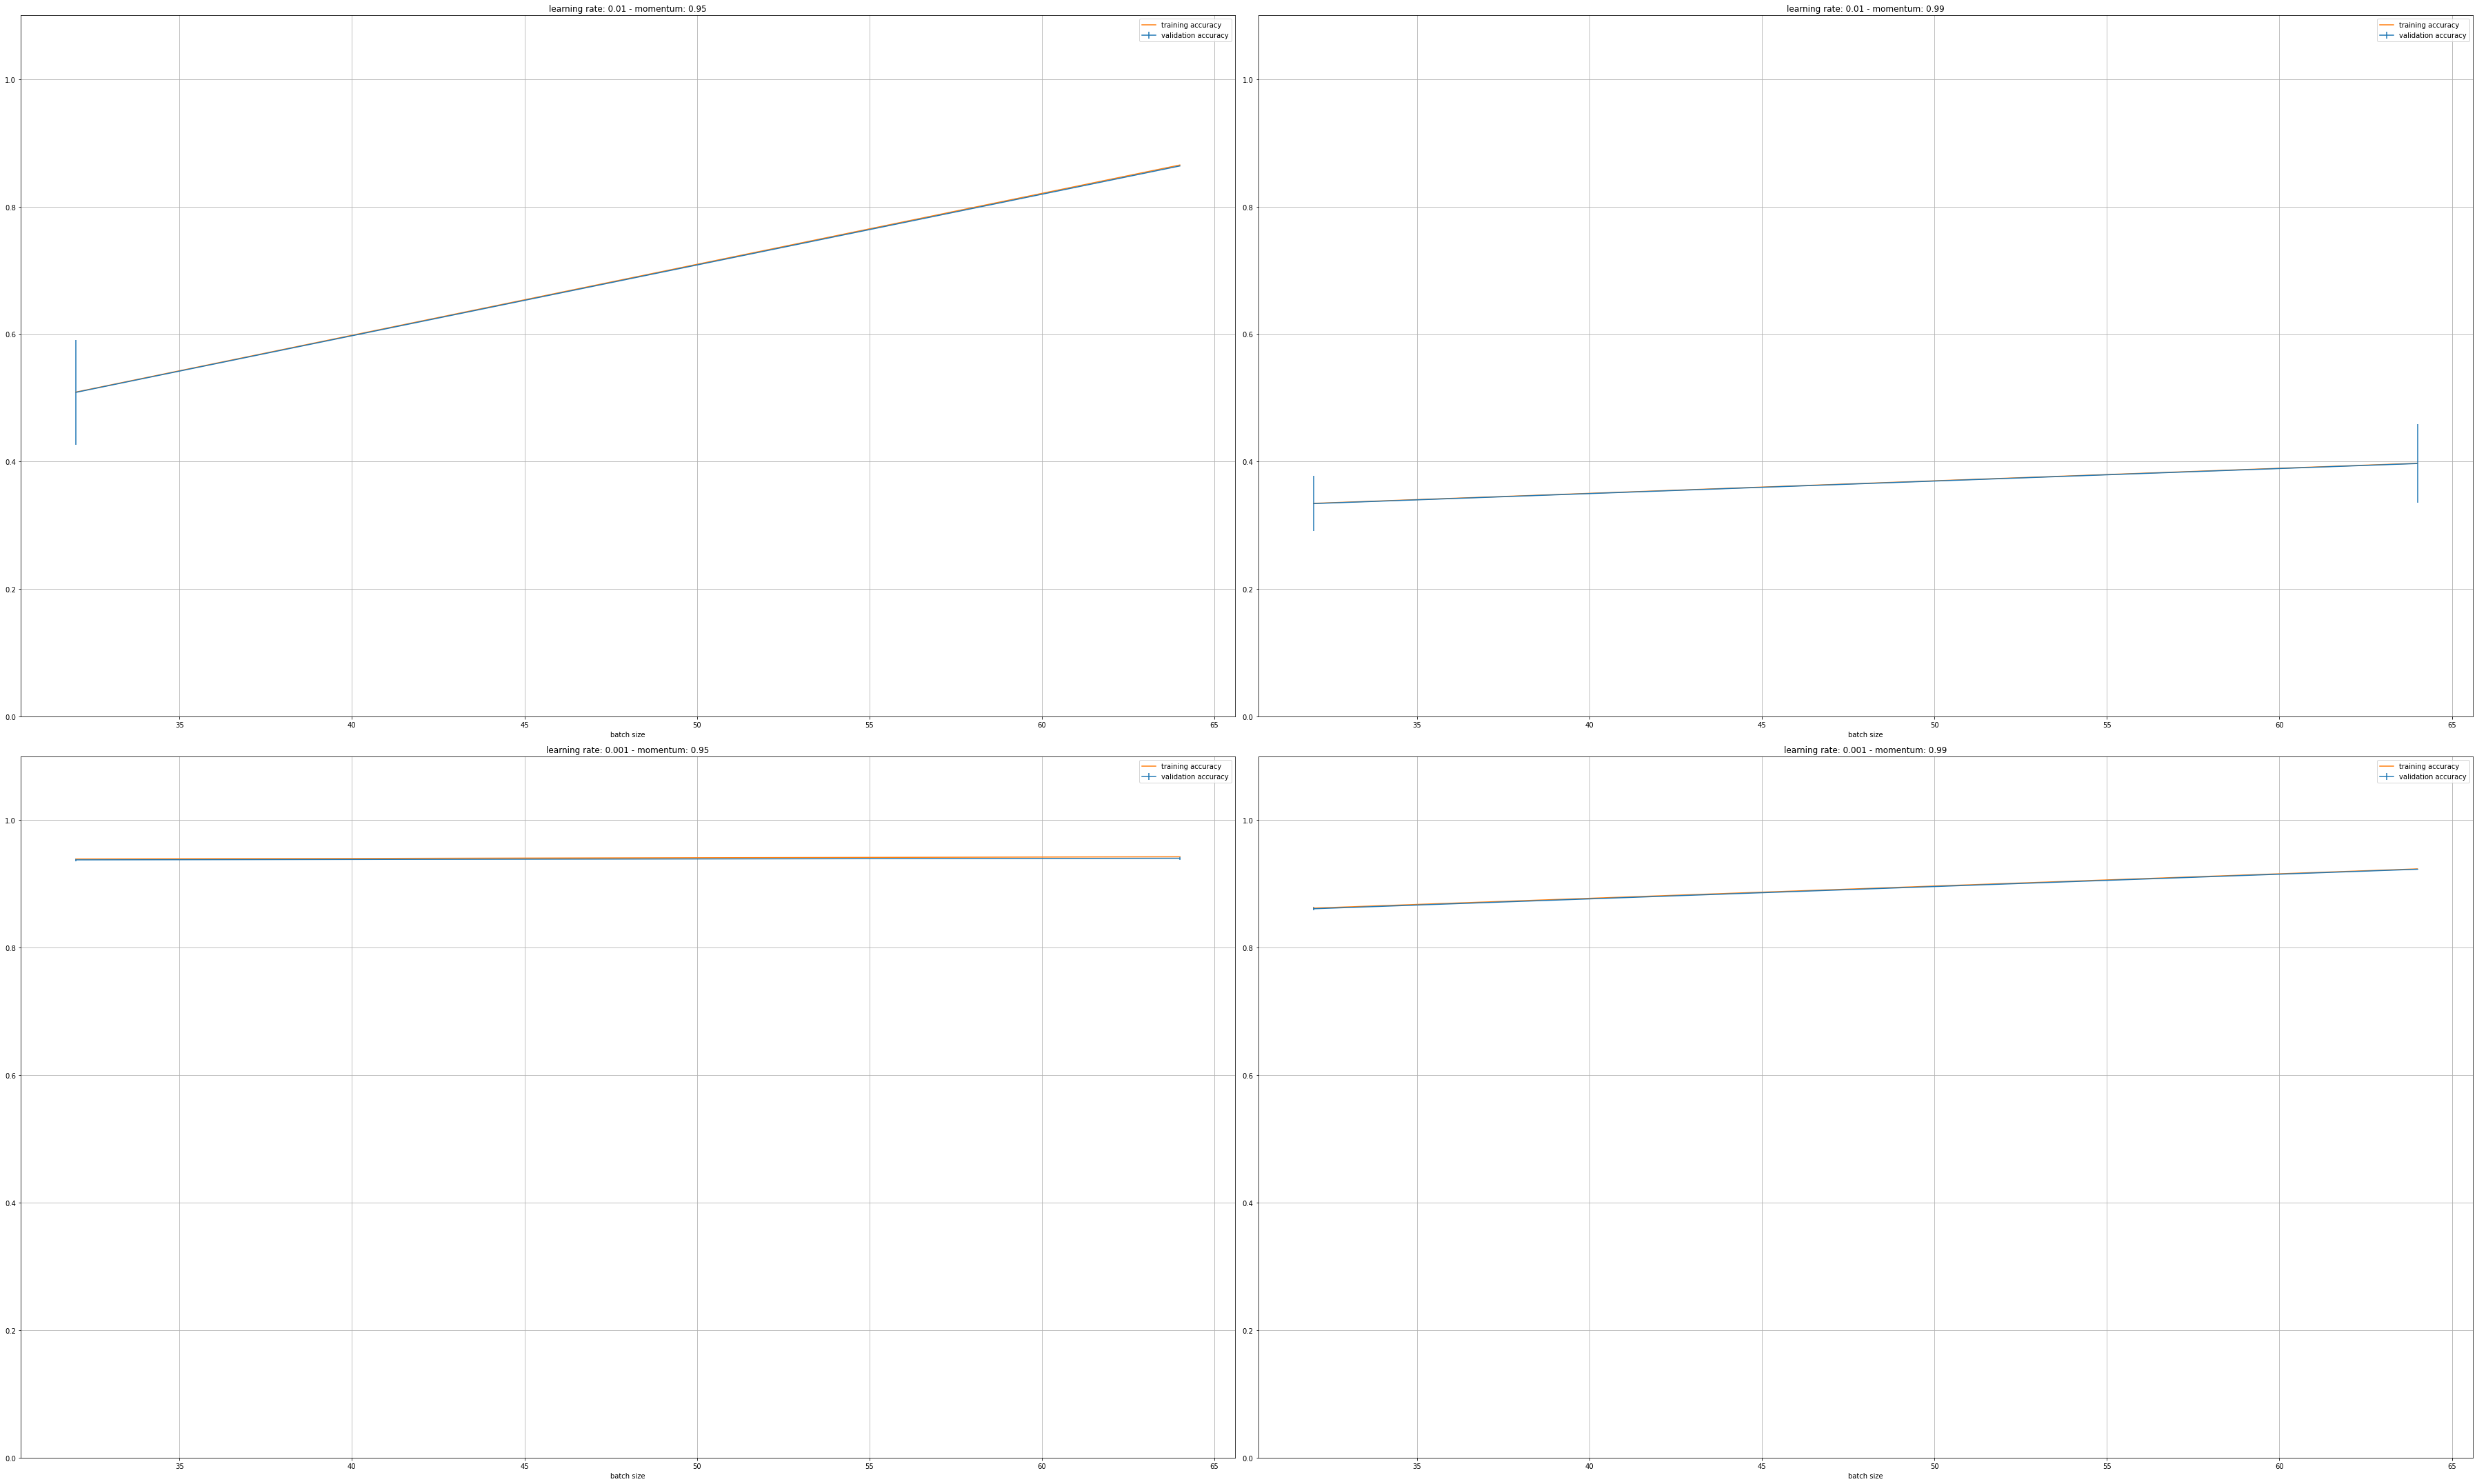

In [13]:
def plot_acc_vs_hyperparam(hyper_grid, hyperparam, ylim=(0,1), figsize=(50, 30)):
    #get the other 2 hyperparameters
    other_hp_1, other_hp_2 = [hp for hp in ['learning rate', 'momentum', 'batch size'] if hp != hyperparam]
    #the dfs of the mean training and validation accuracies, where the index of the dfs is the given hyperparam
    #(the other two are made into columns via the unstack method)
    val_acc_means_and_vars = hyper_grid.unstack(level=[other_hp_1, other_hp_2]).loc[:, ['val_acc_mean', 'val_acc_var']]
    tr_acc_means = hyper_grid.unstack(level=[other_hp_1, other_hp_2])['tr_acc_mean']
    #number of axs to create
    n_axs = tr_acc_means.shape[1]    
    #number of different values of the first "other" hyperparameter
    n_other_1 = len(tr_acc_means.columns.levels[0])
    #number of different values of the second "other" hyperparameter
    n_other_2 = len(tr_acc_means.columns.levels[1])
    
    #our figure consists of n_other_1Xn_other_2 subplots (axs), 
    #on each axs the accuracy is plotted vs the given hyperparam
    fig, axs = plt.subplots(nrows=n_other_1, ncols=n_other_2, figsize=figsize)
    axs = axs.ravel()
    for a in range(n_axs):
        ax=axs[a]
        idx = pd.IndexSlice
        #get the values of the 2 other hyperparameters
        other_hp_1_value = tr_acc_means.columns[a][0]
        other_hp_2_value = tr_acc_means.columns[a][1]
        #plot the accuracy means and the variances for the validation and the means for training 
        val_acc_means_and_vars.plot(ax=ax, y=('val_acc_mean', other_hp_1_value, other_hp_2_value),
                                    title=f'{other_hp_1}: {other_hp_1_value} - {other_hp_2}: {other_hp_2_value}',
                                    yerr=2*val_acc_means_and_vars.loc[idx[:, ('val_acc_var', other_hp_1_value, other_hp_2_value)]])
        tr_acc_means.plot(ax=ax, y=(other_hp_1_value, other_hp_2_value), grid=True, ylim=ylim)  
                                              
        ax.legend(["training accuracy", "validation accuracy"]);
                                                                              
    plt.tight_layout()
#we plot accuracy vs one of ['learning rate', 'momentum', 'batch size'] -- strings must be exact
#if some plots don't have a line, change the ylim.
plot_acc_vs_hyperparam(hyper_grid, 'batch size', ylim=(0.,1.1))